In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import json
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt

from browsermobproxy import Server, Client
from selenium import webdriver

%load_ext autoreload
%autoreload 2

In [2]:
def is_json(fname):
    with open(fname) as f:
        try:
            json.load(f)
            return True
        except Exception:
            return False
        
def postprocess_har(aggregate_har, base_path=None):
    test_pdf = parse_har(aggregate_har)
    test_pdf.sort_values(by=['start_time'])
    
    test_pdf['relative'] = test_pdf.start_time.astype(np.int64) // 10 ** 9
    test_pdf['relative'] = test_pdf['relative'] - min(test_pdf['relative'])
    test_pdf = test_pdf.sort_values(by=['relative'])
    
    if base_path is not None:
        test_pdf = test_pdf[test_pdf["url"].str.contains(base_path)]
    return test_pdf

def parse_har(list_of_har):
    traces = []
    for har_tup in list_of_har:
        # TODO: fix this relative time calculation
        time = har_tup[0]
        har = har_tup[1]
        entries = har['log']['entries']
    
        features = ['url', 'start_time', 'response_code', 'body_size', 'rtt']
        for req in entries:
            try:
                # TODO: fix this relative time
                start_time = parse(req['startedDateTime'])
                start_time += datetime.timedelta(minutes=time)
                url = req['request']['url']
                response_code = req['response']['status']
                body_size = req['response']['bodySize']
                rtt = req['time']
                
                traces.append((url, start_time, response_code, body_size, rtt))
            except:
                # Ignore this trace
                pass
        
    return pd.DataFrame(traces, columns=features)

In [3]:
from typing import List, Tuple
color_palette = [
    'royalblue',
    'orange',
    'mediumseagreen',
    'mediumorchid',
    'orangered',
    "slategray",
    "lightpink",
    "lightsalmon",
    "olive",
    "aqua"
]

# The input data_frame must have column 'relative' and 'url', where relative in the request's integer second from the start
def plot_frequency(ax, data_frame: pd.DataFrame, plot_url: str, mission_seconds: int, color: str, rolling_window_seconds: int = 240, xclip: Tuple[int, int]=(-1,-1)):
    # Filter by the URL that we want to plot
    plot_pdf = data_frame[data_frame['url'] == plot_url]
    # Get how many requests to this URL in a relative time window
    plot_pdf = plot_pdf.groupby(['relative']).size()
    plot_pdf = plot_pdf.to_frame().reset_index().rename(columns={0:'count'})
    # Fill in the missing time window
    plot_pdf.index = plot_pdf['relative']
    plot_pdf = plot_pdf.reindex(np.arange(0, mission_seconds)).fillna(0).astype(int).drop(columns=['relative']).reset_index()
    # Calculate the rolling average of the frequency
    plot_pdf['count_rolling'] = plot_pdf.rolling(window=rolling_window_seconds)['count'].mean().fillna(0)


    ax.plot(plot_pdf['relative'], plot_pdf['count'], label="Freq [{}]".format(plot_url), alpha=0.1, color=color)
    ax.plot(plot_pdf['relative'], plot_pdf['count_rolling'], label="Freq (4m rolling) [{}]".format(plot_url), color=color)
    ax.legend(loc='upper right')
    
    if xclip != (-1,-1):
        plot_pdf = plot_pdf.iloc[xclip[0]:xclip[1]]
    
    return plot_pdf

def plot_frequencies(data_frame: pd.DataFrame, plot_urls: List[str], mission_seconds: int, rolling_window_seconds: int = 240, xlim: Tuple[int] = (-1,-1), ylim: Tuple[int] = (0, 10), xclip: Tuple[int, int]=(-1,-1), color_palette: List[str] = color_palette):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18, 8)
    fig.set_dpi(600)
    
    index = 0
    freq_pdfs = []
    for plot_url in plot_urls:
        freq = plot_frequency(
            ax, 
            data_frame, 
            plot_url, 
            mission_seconds, 
            color_palette[index % len(color_palette)],
            rolling_window_seconds,
            xclip
        )
        
        freq_pdfs.append(freq)
        
        index += 1
    
    
    plt.xlabel("Mission Time (sec)")
    plt.ylabel("Frequency")
    plt.ylim(ylim)
    plt.xlim((0, mission_seconds) if xlim [0] == -1 else xlim)
    plt.title("Frequency of Access")
    
    return freq_pdfs

In [4]:
# The input data_frame must have column 'relative' and 'url', where relative in the request's integer second from the start
def frequency(data_frame: pd.DataFrame, plot_url: str, mission_seconds: int, rolling_window_seconds: int = 240, xclip: Tuple[int, int]=(-1,-1)):
    # Filter by the URL that we want to plot
    pdf = data_frame[data_frame['url'] == plot_url]
    # Get how many requests to this URL in a relative time window
    pdf = pdf.groupby(['relative']).size()
    pdf = pdf.to_frame().reset_index().rename(columns={0:'count'})
    # Fill in the missing time window
    pdf.index = pdf['relative']
    pdf = pdf.reindex(np.arange(0, mission_seconds)).fillna(0).astype(int).drop(columns=['relative']).reset_index()
    # Calculate the rolling average of the frequency
    pdf['count_rolling'] = pdf.rolling(window=rolling_window_seconds)['count'].mean().fillna(0)
    if xclip != (-1,-1):
        pdf = pdf.iloc[xclip[0]:xclip[1]]
    
    return pdf

In [5]:
base_path = "cs.uchicago.edu"

In [6]:
gen_trace = False

# ---------------------
num_worker = 1
num_user = 1
mission_hour = 1
# ---------------------

mission_minutes = mission_hour*60
mission_seconds = mission_hour*60*60

# ---------------------

if gen_trace:
    aggregate_har, sys = gen_trace(base_path, num_user, mission_minutes, num_worker)

In [7]:
# Load the HAR dict pickle file
gatech_har = pickle.load(open("user_200_hour_4_cs.uchicago.edu.har", "rb"))
gatech_processed = postprocess_har(gatech_har, base_path)
url_pdf = gatech_processed.groupby('url').size().sort_values(ascending=False)
url_pdf.head(5)

url
https://cs.uchicago.edu/                                                                          748
https://howto.cs.uchicago.edu/lib/exe/js.php?t=dokuwiki&tseed=ec22f390edf26eae4ffeee9e97521674    599
https://howto.cs.uchicago.edu/lib/exe/jquery.php?tseed=f0349b609f9b91a485af8fd8ecd4aea4           589
https://cs.uchicago.edu/wp-content/themes/csuc/build/fonts/GothamNarrSSm-Black_Web.woff2          391
https://cs.uchicago.edu                                                                           373
dtype: int64

In [8]:
len(url_pdf)

5703

In [9]:
urls = url_pdf.reset_index()['url'].tolist()

In [10]:
urls[0]

'https://cs.uchicago.edu/'

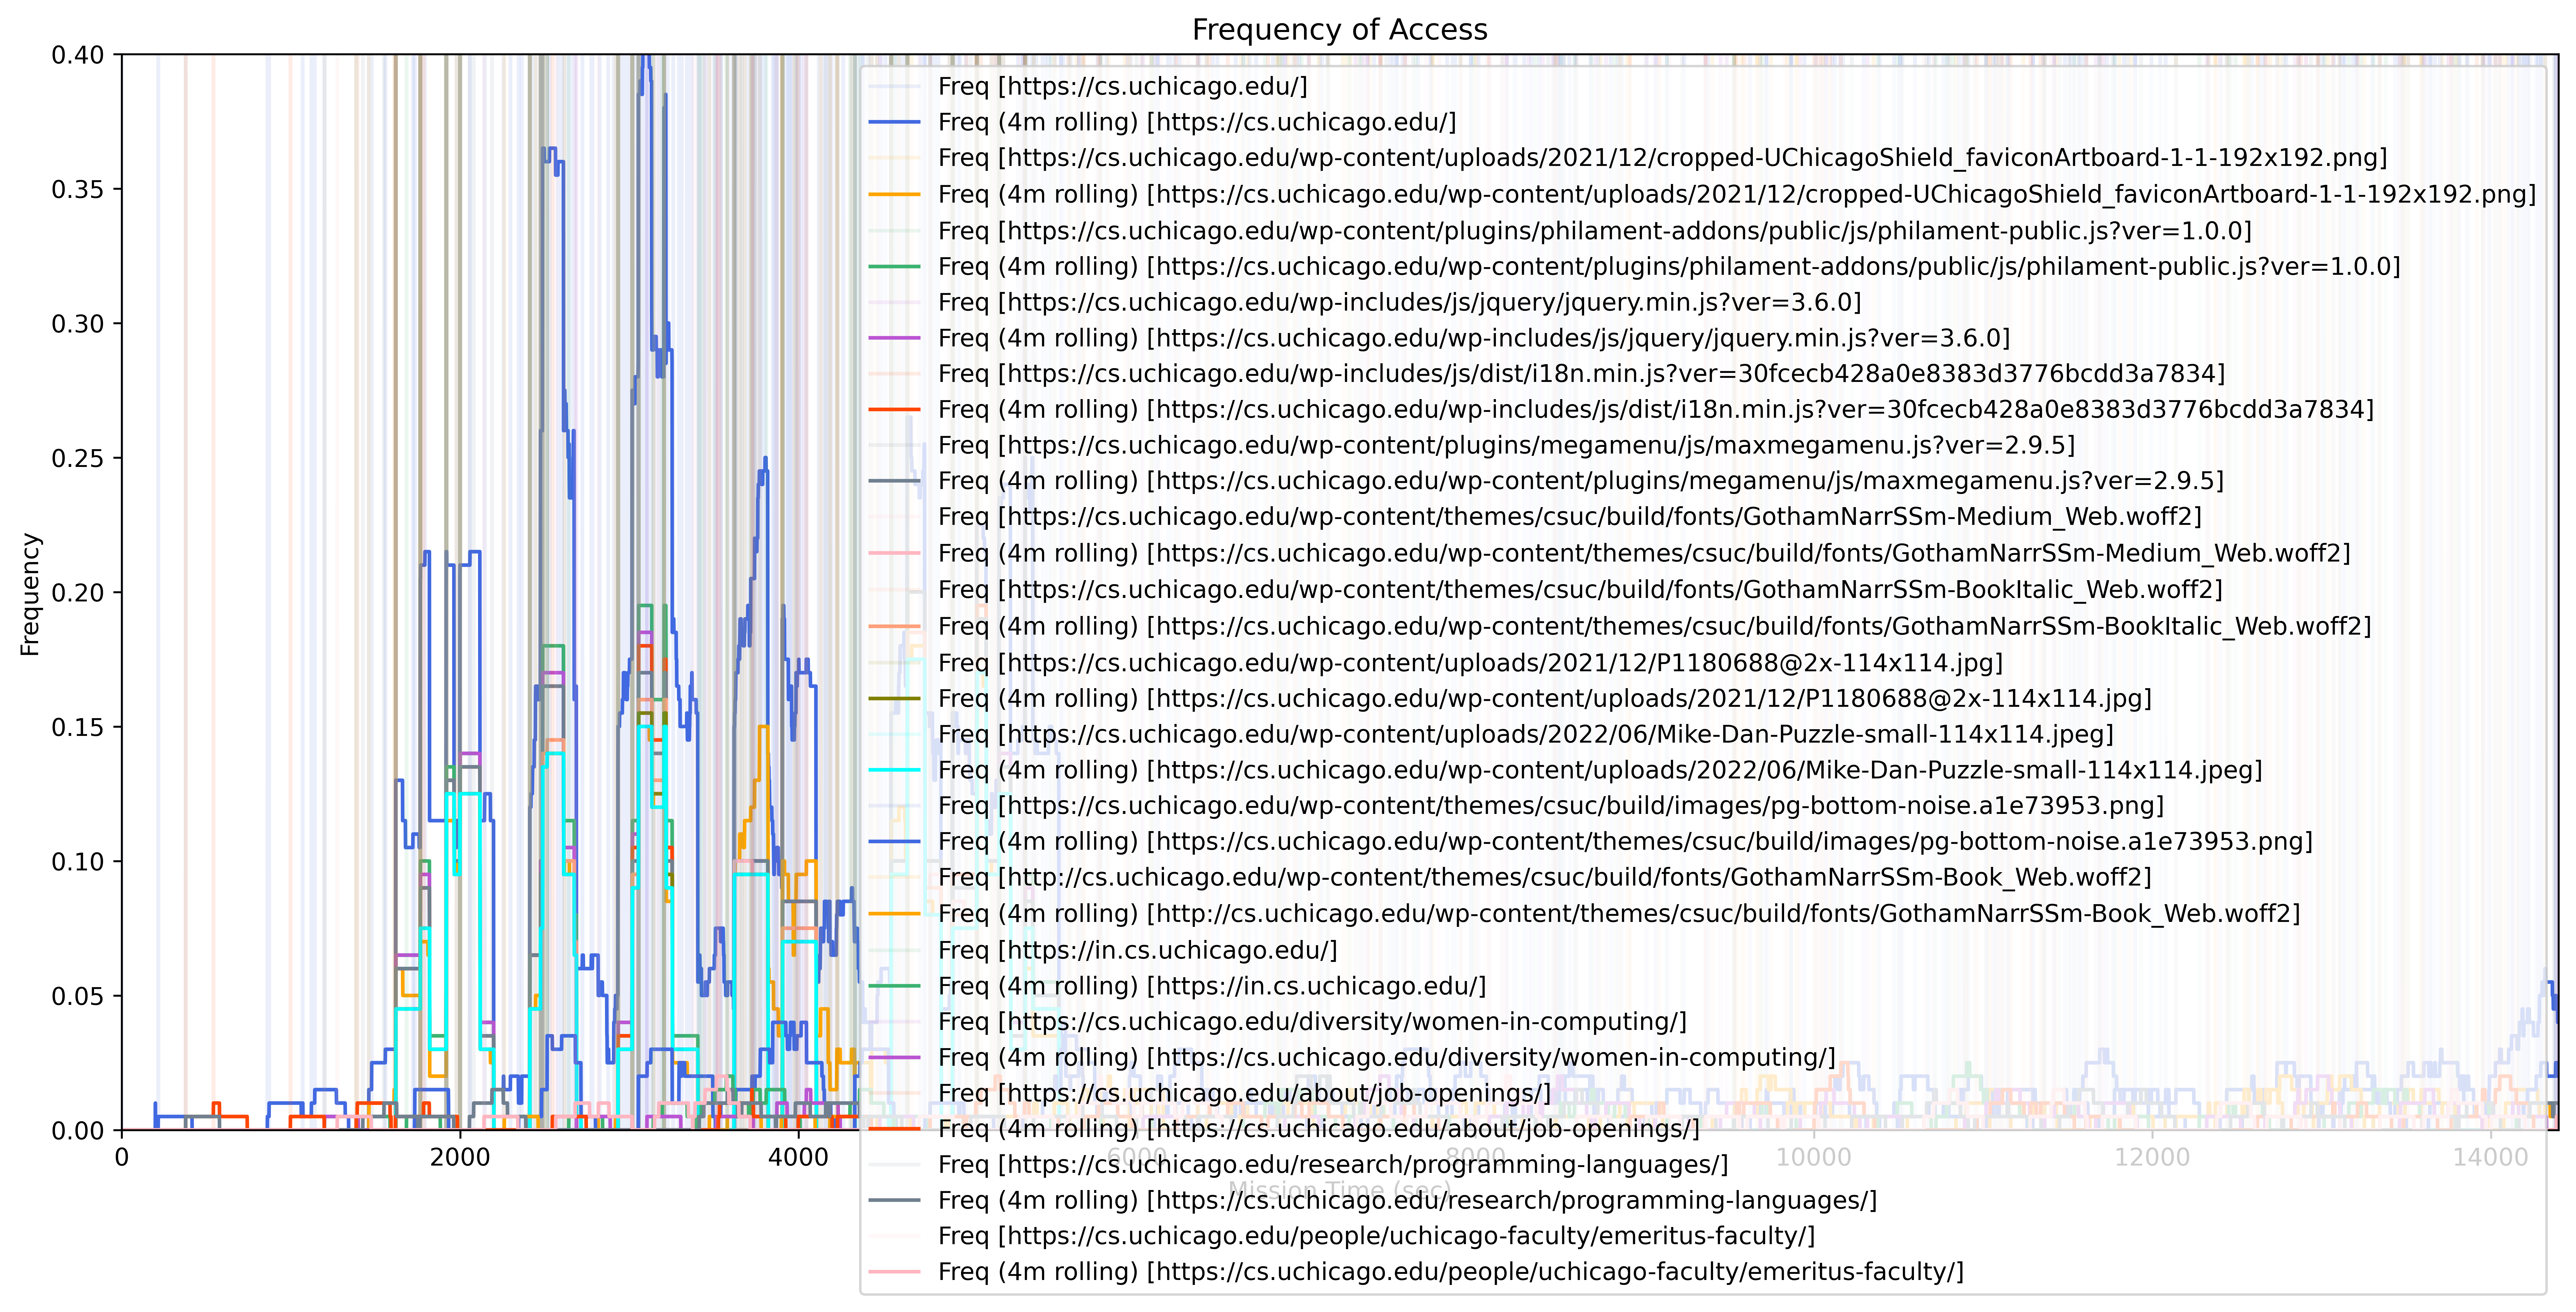

In [11]:
plot_urls = urls[0:100:6]
xclip=(0,4*3600)

frequency_pdfs = plot_frequencies(
    gatech_processed,
    plot_urls,
    4*60*60,
    200,
    (0,4*3600),
    (0,0.40)
)

In [12]:
len(frequency_pdfs)
len(plot_urls)

17

In [13]:
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_train(freq_pdf, seq_length, output_size):
    series = freq_pdf['count_rolling'].to_numpy()
    xs, ys = [], []
    for i in range(len(series) - seq_length - output_size - 1):
        xs.append(series[i:(i+seq_length)])
        ys.append(series[i+seq_length:i+seq_length+output_size])
        
    return torch.from_numpy(np.array(xs)).float().unsqueeze(-1), torch.from_numpy(np.array(ys)).float()

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=False,
            dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )
        
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
                
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 50
num_layers = 2
output_size = 150
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

learning_rate = 1e-4

criteria = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = torch.optim.lr_scheduler.StepLR(verbose=False, optimizer=optimizer, gamma=0.1, step_size=40)

window_size=300

X, Y = gen_train(frequency_pdfs[0], window_size, output_size)
Y = Y.reshape(-1,output_size)
stack_num = 3
for i in range(1,(stack_num+1)*2,2):
    X1, Y1 = gen_train(frequency_pdfs[i], window_size, output_size)
    Y1 = Y1.reshape(-1,output_size)
    X = torch.vstack((X,X1))
    Y = torch.vstack((Y,Y1))

Y = Y.reshape(-1,output_size)

print(X.shape)
print(Y.shape)

torch.Size([69745, 300, 1])
torch.Size([69745, 150])


In [14]:
from torch.utils.data import DataLoader, TensorDataset

dataset_train = TensorDataset(X, Y)
dataloader = DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=24, pin_memory=True)

In [16]:
# num_epochs = 10
# losses = []

# for epoch in range(num_epochs):
#     for id_batch, (x_batch, y_batch) in enumerate(dataloader):
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.to(device)
#         # print(y_batch)
#         outputs = model(x_batch)
#         # print(outputs)
#         y_batch = y_batch.reshape(outputs.shape)
        
#         optimizer.zero_grad()
#         # Attempt to penalize hard for negative value outputs
#         loss = criteria(outputs, y_batch) + torch.any(outputs < 0).long().cpu()
#         loss.backward()
#         optimizer.step()
        
#     lr_scheduler.step()
        
#     print("Epoch: {}/{}, Loss: {:.8f}".format(epoch+1, num_epochs, loss.item()))
#     losses.append(loss.item())

# plt.plot(range(0, num_epochs), losses)

In [15]:
# # model = torch.load('model.pt')
model.load_state_dict(torch.load('model.pt', map_location=device))
model.eval()

LSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.4)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=150, bias=True)
    (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [18]:
# def infer_plot_pred(test_pdf, url):
#     test_X, _ = gen_train(test_pdf, window_size, output_size)

#     dataset_test = TensorDataset(test_X)
#     dataloader_test = DataLoader(dataset_test, batch_size=64)

#     model.eval()
#     y_test_preds = []
#     for id_batch, (x_batch) in enumerate(dataloader_test):
#         x_batch = x_batch[0].to(device)
#         y_pred = model(x_batch)
#         y_pred = y_pred.cpu().detach().numpy()
        
#         for batch_pred in y_pred:
#             # print(batch_pred.shape)
#             y_test_preds.append(batch_pred[-1])
    
#     model.train()
#     plt.figure(figsize=(30, 4), dpi=200)
#     plt.plot(test_pdf['count_rolling'], label="True Freq")
#     plt.plot([0]*window_size + [0]*xclip[0] + y_test_preds, label="Prediction")
#     plt.xlim(xclip)
#     # plt.ylim((0, 0.25))
#     plt.title("URL: {}".format(url))
#     plt.legend(loc='upper right')

# for i in range(len(frequency_pdfs)):
#     infer_plot_pred(frequency_pdfs[i], plot_urls[i])

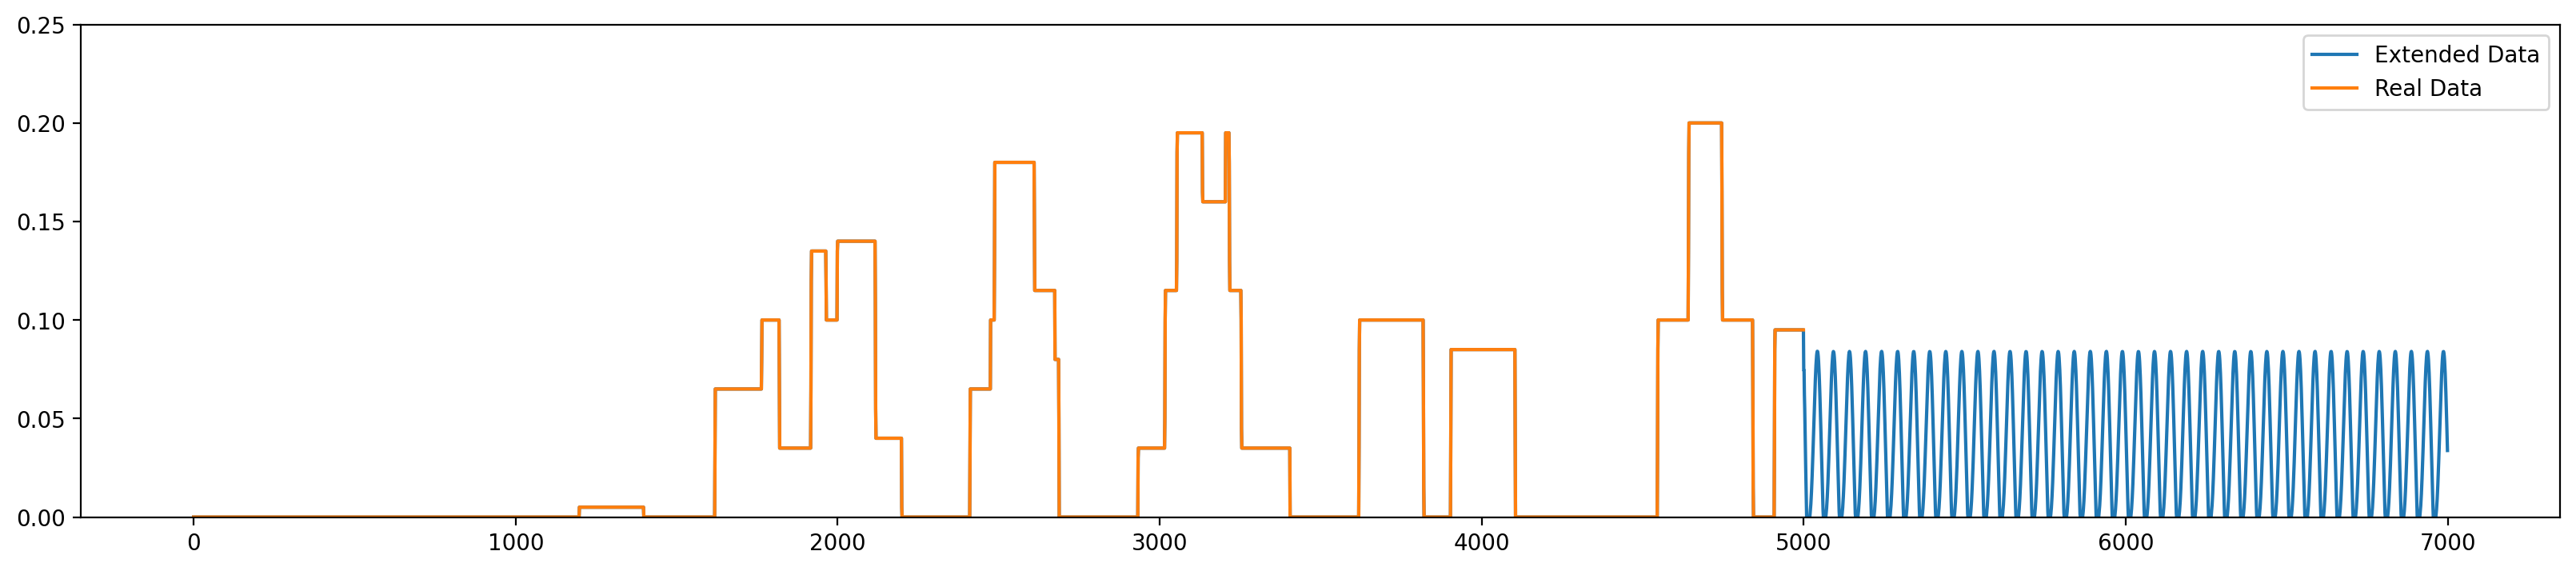

In [16]:
import copy

real_data = frequency_pdfs[2]['count_rolling'].to_numpy()[xclip[0]:5000]

extend_count = 2000  
extended_data = list(copy.deepcopy(real_data))

model.eval()

for i in range(extend_count):
    x_input = extended_data[-1-window_size:-1]
    x_input = torch.Tensor(x_input).to(device).reshape((1, window_size, 1))
    
    y_pred = model(x_input)
    y_pred = y_pred.cpu().detach().numpy()
    
            
    extended_data.append(y_pred.flatten().tolist()[-1])

model.train()    
plt.figure(figsize=(20, 4), dpi=200)

plt.plot(extended_data, label='Extended Data')
plt.plot(real_data, label="Real Data")
plt.ylim(0, 0.25)
plt.legend(loc='upper right')

In [20]:
# Save model
# torch.save(model.state_dict(), "model.pt")

CDN

In [17]:
import pickle
from util import parse_har

In [18]:
# Load the HAR dict pickle file
uchicago_har = pickle.load(open("user_600_hour_6_cs.uchicago.edu.har", "rb"))
uchicago_har = parse_har(uchicago_har)

In [19]:
uchicago_har = uchicago_har.sort_values('start_time', ascending = True)
uchicago_har = uchicago_har[uchicago_har['start_time'] < '2023-11-27 23:27:41']

In [20]:
class CDN:
    
    # The CDN implements a clock-handle 
    def __init__(self, size_mb: int) -> None:
        self.size = size_mb * 1024 * 1024
        self.hashmap = {}
        self.current_size = 0
    
        # Counters
        self.total_requests = 0
        self.hit = 0
        
        self.prediction = False
        self.time_window_start = 0
        
        # Related to LSTM time quanta
    
    def fetch(self, path: str, size: int):
        # print("Accessing {}".format(path))
        self.total_requests += 1
        # Has it cached, return, do nothing
        # NOTE: we ignore CDN's fetching update, not important
        if path in self.hashmap:
            self.hit += 1
            # Pop and Push, Python Dict maintains insertion order
            value = self.hashmap.pop(path)
            self.hashmap[path] = value
            
            return value
        
        # Not cached, we need to grab
        if self.current_size + size > self.size:
            if self.prediction == False:
                self.evict(size)
            else: 
                self.evict_with_prediction(size)
                
            
        # After evict, we insert
        self.hashmap[path] = (path, size)
        self.current_size += size
        # print("Newly cached. Size now is {}/{} bytes, {:.2f}% full".format(self.current_size, self.size, self.current_size/self.size*100))
        
    def evict(self, incoming_size):
        # Remove the head of the dict, until size+self.current_size < self.size_mb
        while self.current_size + incoming_size > self.size:
            # Pop the head
            key = next(iter(self.hashmap))
            value = self.hashmap.pop(key)
            
            self.current_size -= value[1]
            # print("Evicting {}".format(key))
            
    def evict_with_prediction(self, incoming_size):
        # Remove the head of the dict, until size+self.current_size < self.size_mb
        print('self.time_window_start')
        while self.current_size + incoming_size > self.size:
            # Pop the head
            print(self.time_window_start)
            if self.time_window_start > 500:
                
                # print('t1')
                list_key = list(self.hashmap.keys()).copy()
                for urls_ in list_key:
                    # print(urls_)
                    # print('t2')
                    # xclip=(0,4*3600)
                    frequency_pdfs = frequency(
                        gatech_processed,
                        urls_,
                        4*60*60,
                        200,
                        (0,4*3600),
                    )
                    frequency_pdfs
                    # print()
                    # print('t2d')
                    extended_data = list(frequency_pdfs['count_rolling'].to_numpy()[self.time_window_start - 150:self.time_window_start])
                    # print('len',len(extended_data))
                    # print(sum(frequency_pdfs['count_rolling'].to_numpy()))
                    x_input = extended_data
                    # print('t2s')
                    x_input = torch.Tensor(x_input).to(device).reshape((1, 150, 1))
                    # print('t3')
                    model.eval()
                    y_pred = model(x_input)
                    y_pred = y_pred.cpu().detach().numpy()
                    if np.sum(y_pred) < 1:
                        key = urls_
                        value = self.hashmap.pop(key)
                        self.current_size -= value[1]
                        exit()
            key = next(iter(self.hashmap))
            value = self.hashmap.pop(key)
            
            self.current_size -= value[1]
            # print("Evicting {}".format(key))

In [21]:
cdn = CDN(100)

for row in uchicago_har.iloc():
    path = row['url']
    size_mb = row['body_size']
    
    cdn.fetch(path, size_mb)

In [22]:
print("Hit Ratio With no Prediction: {:.2f}%".format(cdn.hit/cdn.total_requests*100))

Hit Ratio With no Prediction: 84.30%


In [23]:
cdn = CDN(100)
cdn.prediction = True
count = 0
# print(len(uchicago_har))
for row in uchicago_har.iloc():
    # print(count)
    count += 1 
    path = row['url']
    size_mb = row['body_size']
    cdn.time_window_start = round((row.start_time - uchicago_har.start_time.min()).total_seconds() )
    cdn.fetch(path, size_mb)
    if cdn.time_window_start > 4000:
        break

self.time_window_start
2882


: 

In [ ]:
cdn.total_requests